# Human Skeleton Pose CNN model creation



Setup

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import PIL
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

import pathlib
import os

import warnings
warnings.filterwarnings('ignore')

setting up the folder

In [2]:
data_dir = pathlib.Path('CNN_DATASET/TRAIN_MLP').with_suffix('')  # using the pose images

image_count = len(list(data_dir.glob('*/*.jpg')))
print(image_count)

6562


Creating the dataset

In [3]:
batch_size = 32
img_height = 270
img_width = 480

train_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  labels='inferred',
  color_mode='rgb',
  validation_split=0.2,
  subset="training",
  seed=13,
  image_size=(img_height, img_width),
  batch_size=batch_size)

val_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  labels='inferred',
  color_mode='rgb',
  validation_split=0.2,
  subset="validation",
  seed=13,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 6562 files belonging to 3 classes.
Using 5250 files for training.
Found 6562 files belonging to 3 classes.
Using 1312 files for validation.


In [4]:
class_names = train_ds.class_names
print(class_names)

['shooting', 'sitting', 'standing']


Visualize the data (no need to be run unless you are curious about the data)

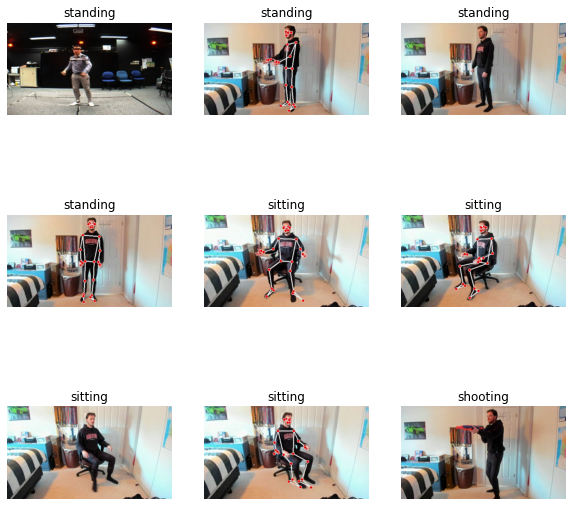

In [5]:
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i]])
        plt.axis("off")

In [6]:
for image_batch, labels_batch in train_ds:
    print(image_batch.shape)
    print(labels_batch.shape)
    break

(32, 270, 480, 3)
(32,)


Configure the dataset for performance

In [7]:
AUTOTUNE = tf.data.AUTOTUNE

#train_ds = train_ds.cache().shuffle(1024).prefetch(buffer_size=AUTOTUNE)
train_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

Data augmentation (if needed)

In [ ]:
data_augmentation = keras.Sequential(
  [
    #layers.RandomFlip("horizontal", input_shape=(img_height, img_width, 3)),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1),
  ]
)


Visualize the data (no need to be run unless you are curious of the data from data_augmentation)

In [ ]:
plt.figure(figsize=(10, 10))
for images, _ in train_ds.take(1):
  for i in range(9):
    augmented_images = data_augmentation(images)
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(augmented_images[0].numpy().astype("uint8"))
    plt.axis("off")


Create the model - network

In [8]:
num_classes = len(class_names)

model = Sequential([
    layers.Rescaling(1./255, input_shape=(img_height, img_width, 3)),     # Normalize the input data
#  data_augmentation,    
    layers.Conv2D(32, 3, padding='same', activation='relu'),
    layers.Conv2D(32, 3, padding='same', activation='relu'),
    layers.BatchNormalization(),
    layers.MaxPooling2D(),
    layers.Conv2D(64, 3, padding='same', activation='relu'),
    layers.Conv2D(64, 3, padding='same', activation='relu'),
    layers.BatchNormalization(),
    layers.MaxPooling2D(),
    layers.Conv2D(128, 3, padding='same', activation='relu'),
    layers.Conv2D(128, 3, padding='same', activation='relu'),
    layers.BatchNormalization(),
    layers.MaxPooling2D(),
    layers.Conv2D(256, 3, padding='same', activation='relu'),
    layers.Conv2D(256, 3, padding='same', activation='relu'),
    layers.BatchNormalization(),
    layers.MaxPooling2D(),
    layers.Flatten(),
    layers.Dropout(0.2, input_shape=(2,)),   
    layers.Dense(256, activation='relu'),
    layers.Dense(128, activation='relu'),
    layers.Dense(64, activation='relu'),
    layers.Dense(32, activation='relu'),
    layers.Dropout(0.2, input_shape=(2,)),   
    layers.Dense(num_classes, activation ='softmax')
])

Compile the model

In [9]:
model.compile(
  optimizer='adam',
  loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
  metrics=['accuracy'])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling (Rescaling)       (None, 270, 480, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 270, 480, 32)      896       
                                                                 
 conv2d_1 (Conv2D)           (None, 270, 480, 32)      9248      
                                                                 
 batch_normalization (BatchN  (None, 270, 480, 32)     128       
 ormalization)                                                   
                                                                 
 max_pooling2d (MaxPooling2D  (None, 135, 240, 32)     0         
 )                                                               
                                                                 
 conv2d_2 (Conv2D)           (None, 135, 240, 64)      1

Train the model

In [10]:
epochs=20
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/20
165/165 [==============================] - 1364s 8s/step - loss: 0.7855 - accuracy: 0.9314 - val_loss: 40.7075 - val_accuracy: 0.2660
Epoch 2/20
165/165 [==============================] - 1361s 8s/step - loss: 0.1708 - accuracy: 0.9787 - val_loss: 2.2548 - val_accuracy: 0.8979
Epoch 3/20
165/165 [==============================] - 1346s 8s/step - loss: 0.0296 - accuracy: 0.9950 - val_loss: 0.0810 - val_accuracy: 0.9977
Epoch 4/20
165/165 [==============================] - 1325s 8s/step - loss: 0.0093 - accuracy: 0.9983 - val_loss: 0.1476 - val_accuracy: 0.9939
Epoch 5/20
165/165 [==============================] - 1326s 8s/step - loss: 0.0070 - accuracy: 0.9994 - val_loss: 0.0475 - val_accuracy: 0.9985
Epoch 6/20
165/165 [==============================] - 1326s 8s/step - loss: 5.5559e-04 - accuracy: 0.9998 - val_loss: 0.0483 - val_accuracy: 0.9985
Epoch 7/20
165/165 [==============================] - 1380s 8s/step - loss: 2.0114e-04 - accuracy: 1.0000 - val_loss: 0.0472 - val_

Visualize training results

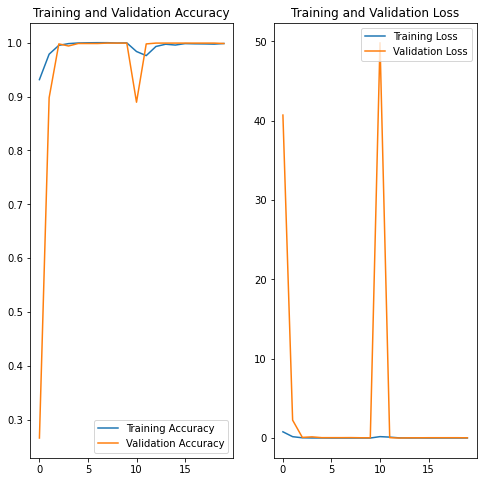

In [11]:
# set the labels
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

# set the x range
epochs_range = range(epochs)

# display the 2 training/validating graphs
plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()


Predict on new data

1/1 [==============================] - 0s 175ms/step
This image most likely belongs to shooting with a 57.61 percent confidence.
[[1. 0. 0.]]


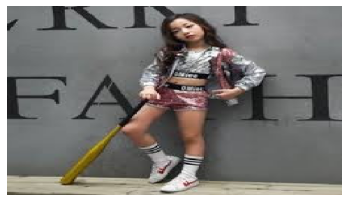

In [18]:
img = tf.keras.utils.load_img('DATASET/TEST/image_25.jpg', target_size=(img_height, img_width))
#img = tf.keras.utils.load_img('DATASET/TEST/image_30.jpg')

# preparing the image for prediction
img_array = tf.keras.utils.img_to_array(img)
img_array = tf.expand_dims(img_array, 0) # Create a batch

# running the prediction on the image array
predictions = model.predict(img_array)
score = tf.nn.softmax(predictions[0])

# display the image
plt.imshow(img)
plt.axis("off")

#print the prediction result
print(
    "This image most likely belongs to {} with a {:.2f} percent confidence."
    .format(class_names[np.argmax(score)], 100 * np.max(score)) )
print(predictions)
plt.show()


Convert the Keras Sequential model to a TensorFlow Lite model - and saving it

In [13]:
# Convert the model.
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()

# Save the model.
with open('model.tflite', 'wb') as f:
  f.write(tflite_model)

# Print the signatures from the converted model
interpreter = tf.lite.Interpreter(model_content=tflite_model)
signatures  = interpreter.get_signature_list()
print(signatures)


INFO:tensorflow:Assets written to: C:\Users\foxlo\AppData\Local\Temp\tmpgyraf6ye\assets


INFO:tensorflow:Assets written to: C:\Users\foxlo\AppData\Local\Temp\tmpgyraf6ye\assets


{'serving_default': {'inputs': ['rescaling_input'], 'outputs': ['dense_4']}}
